# Fitting time series metabolomics data to the Behrends model

In [1]:
import numpy as np
import pickle
from matplotlib import pylab as plt
from scipy.optimize import leastsq
import pandas as pd
import math

%matplotlib inline

plt.rcParams['pdf.fonttype']=42
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 8})
plt.rcParams['axes.linewidth'] = 2 # set the value globally

### After importing all the necessary packages, load the pickled `data` dictionary

In [7]:
with open('../Data/metabolomics_data.pkl','r') as f:
    data = pickle.load(f)

### Define functions that will be used in this notebook.
1. One that returns the input to the modeled equation
2. One that returns the residual, *i.e.* the error
3. One that can calculate the when a compound has been depleted to half the starting concentration (t-half)
4. One that calculates the rate of compound usage (*i.e.* the derivative of the Behrends equation)

In [8]:
def my_func(t,a,o,p):
    '''
    From:
    Time-Resolved Metabolic Footprinting for Nonlinear Modeling of Bacterial Substrate Utilization
    Behrends, Ebbels, Wiliams, and Bundy
    
    Input
    t: a 1d numpy array representing time points that were sampled
    a: the amplitude between the starting point and the lowest level a metabolite goes to
    o: the offset, which is the final amplitude
    p: the parameters in the model below
    
    Output:
    y: a 1d numpy array representing the magnitude of a given metabolite over time
    
    Model:
    y = a / (1 + np.exp( (t - p[0]) / p[1])) + o
    
    where:
    p[0] is the t_50 or t one-half, which is the time at half-amplitude
    p[1] is the width or time of the exponent to go from 1 to -1

    Authors:
    Ben Bowen and Onur Erbilgin
    2015, December 3
    JGI, Berkeley Lab
    
    '''
    return a / (1 + np.exp( (t - p[0]) / p[1] ) ) + o

def my_residual(p,t,y,a,o):
    '''
    Calculates residual for leastsq.
    Returns a ridiculously high residual if either parameter (p) is negative
    '''
    for i in p:
        if i < 0:
            return y + 1e20
    return y-my_func(t,a,o,p)

def my_func_t(a, o, p, y):
    '''
    Solution of my_func for t, so you can find the time when a metabolite is at a certain concentration
    '''
    return np.log(a/(y-o) - 1) * p[1] + p[0]

def behrends_diff(a, h, w, t):
    '''
    Differentiated behrends equation, gives instantaneous rate of compound usage 
    '''
    return a*np.exp((-h + t)/w)/(w*(np.exp((-h + t)/w) + 1)**2)

* **`my_func`** is the equation based off of a published paper: Behrends *et. al.* 2009:
$$y=\frac{amplitude}{1+e^{-\frac{x-t_{50}}{width}}}+offset$$ 
  * The equation and manuscript actually contained two errors:
    1. The sign on the exponent of *e* was incorrect
    2. The definition of 'offset' was incorrect: the offset is actually the difference between the final concentration and 0, or simply the final amplitude
  * So after fixing the equation and replacing the variables with what we used, it becomes:
$$ \frac{a}{1+e^{\frac{t-p[0]}{p[1]}}}+o$$
  * t50 and offset are represented by items in the list **`p`** just for simplicity


* The **`my_residual`** function is necessary because that's what curve fitting scripts use to refine their paramter "wiggling" while fitting the data.
  * The current curve-fitter we use (`leastsq`) sums the squares of the residual automatically, so we didn't need to do that in our own residual function
  * The **`for`** loop returns an enormous error if any of the parameters are zero. This is necessary to bound the space of what the parameters can be (none of them can be zero!)
  * Otherwise, if the parameters are within our bounds, then the function returns the difference between observed and calculated y

### To make sure that we entered everything correctly, we now test out our curve fitter on some simulated data

t50:        12.0622526833 	 True t50:    12
Width:      0.999014289072 	 True Width:  1
Half point: 12.5725747807


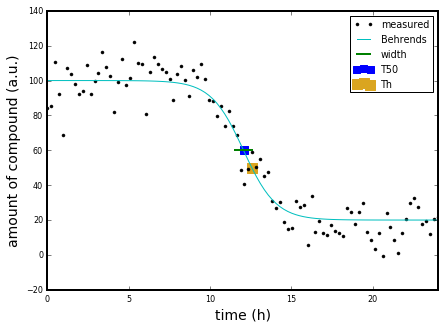

In [9]:
N = 100 #the number of time points
t_max = 24 #max time of experiment

t=np.linspace(0,t_max,N)

#some values to create fake data
o = 20 #offset aka finishing concentration
m = 100 #starting concentration
a = m - o #amplitude
p_create_fake_data = [
    12, #t_50
    1] #width

#simulated y_measured with noise added
y_measured =my_func(t,a,o,p_create_fake_data) + np.random.normal(0,10,N)

#give the fitter an initial guess
p_guess = [
    10, #t_50
    2] #width

#Do the curve fitting
out = leastsq(my_residual,p_guess,args=(t,y_measured,a,o))
y_fit = my_func(t,a,o,out[0])
t50 = out[0][0] #fitted t50
w = out[0][1] #fitted width

#calculate the time at which half of the available compound is eaten (not t50!)
if o < m / 2:
    y = 50.
    hlfpt = my_func_t(a,o,out[0],y)
else:
    hlfpt = 'never eats half'

#compare between fitted and known parameters
print 't50:       ', t50, '\t True t50:   ', p_create_fake_data[0]
print 'Width:     ', w, '\t True Width: ', p_create_fake_data[1]
print 'Half point:', hlfpt

#plot it out
plt.plot(t,y_measured, '.', label='measured', color = 'black')
plt.plot(t,y_fit, label='Behrends', color = 'c')
plt.scatter(t50, my_func(t50,a,o,out[0]), marker = 's', s = 50, color = 'b', label = 'T50')
plt.plot([t50 - w / 2,t50 + w / 2],[my_func(t50,a,o,out[0]),my_func(t50,a,o,out[0])], color = 'green', label = 'width', linewidth = 2)
plt.scatter(hlfpt, my_func(hlfpt,a,o,out[0]), marker = 's', s = 100, color = 'goldenrod', label = 'Th')
plt.legend()
plt.xlim(0,24)
plt.ylabel('amount of compound (a.u.)', fontsize = 14)
plt.xlabel('time (h)', fontsize = 14)
fig = plt.gcf()
fig.set_size_inches(7,5)
plt.show()

The curve fitter performed very well, judging both by eye and comparing the calculated **`t50`** and **`width`** parameters.

### Now that we know the curve fitter works, we can put in the actual data
First, we need to clean up the data, as there are some missing time points, which confuse the curve fitter.

In [10]:
#Discovered that the curve fitting problems were due to empty data being valued at 0, especially for 9B05C, where t0 is 0.
#So fill in the t0 data with the next time point so that the curve fitter doesn't get thrown off

#fixing 9B05C:
for j in range(len(data['dim2'])):
    data['M'][5][j][0] = data['M'][5][j][1]

After the data cleanup, fit the data and store the parameters

Example figure:


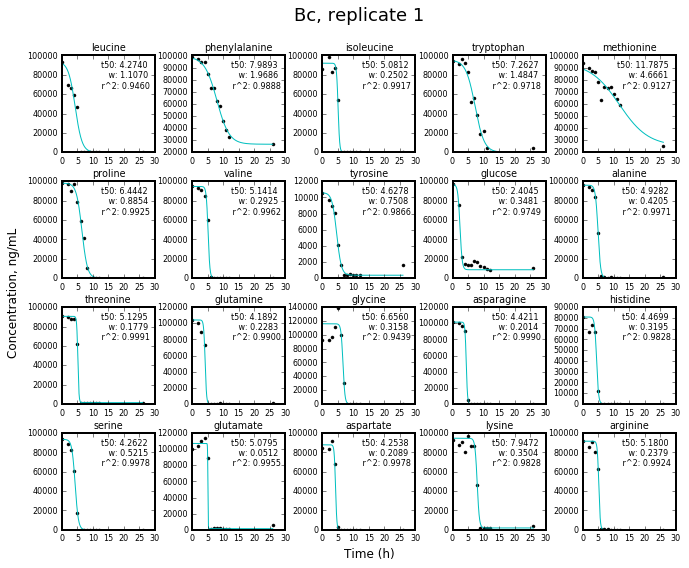

In [11]:
#list of labels for the plot
label = [
    'Bc, replicate 1',
    'Bc, replicate 2',
    'Bc, replicate 3',
    'Pl, replicate 1',
    'Pl, replicate 2',
    'Pl, replicate 3',
    'Pb, replicate 1',
    'Pb, replicate 2',
    'Pb, replicate 3', 
]

#t is the time dimension for the measured data
t = np.asarray(data['dim3'])
#t_fit is the time dimension for fitted curve plotting
t_fit = np.linspace(0,data['dim3'][-1], 10000)

#define the arrays to store the fitted data
data['fit_result'] = np.zeros((len(data['dim1']),len(data['dim2']),2))
data['fit_residual'] = np.zeros((len(data['dim1']),len(data['dim2'])))
data['y_fit'] = np.zeros((len(data['dim1']),len(data['dim2']),len(t_fit)))
data['halfway'] = np.zeros((len(data['dim1']),len(data['dim2'])))
data['parameters'] = np.zeros((len(data['dim1']),len(data['dim2']), 4))
data['maxrate'] = np.zeros((len(data['dim1']),len(data['dim2'])))
data['maxrate_time'] = np.zeros((len(data['dim1']),len(data['dim2'])))
data['window'] = np.zeros((len(data['dim1']),len(data['dim2'])))

fig = plt.figure(1)
ax = fig.add_axes([0,0,1,1])

#for each replicate
for iii in range(len(data['dim1'])):
    plt.clf()
    #make a big subplot for common labeling purposes
    label_ax = fig.add_subplot(111)
    # Turn off axis lines and ticks of the big subplot
    label_ax.spines['top'].set_color('none')
    label_ax.spines['bottom'].set_color('none')
    label_ax.spines['left'].set_color('none')
    label_ax.spines['right'].set_color('none')
    label_ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
    label_ax.set_ylabel('Concentration, ng/mL', labelpad = 25, fontsize = 12)
    label_ax.set_xlabel('Time (h)', fontsize = 12)
    
    #for each compound
    for i in range(len(data['dim2'])):
        y_measured = data['M'][iii,i,:].flatten()
        #set offset to last data point unless that data point is greater than the previous, in which case set it to the previous
        if data['M'][iii][i][-1] > data['M'][iii][i][-2]:
            o = data['M'][iii][i][-2]
        else:
            o = data['M'][iii][i][-1]
            
        #set amplitude to a value in between the max concentration and t0, minus the offset
        a=(y_measured[0] + np.amax(y_measured))/2 - o 
        
        #initial guess for the curve fitter
        p_guess = np.asarray([
            4, #t_50
            1]) #width
        
        #fit the data and store the results
        out = leastsq(my_residual,p_guess,args=(t,y_measured,a,o))
        y_fit = my_func(t_fit,a,o,out[0])
        data['y_fit'][iii,i,:] = y_fit
        data['fit_result'][iii,i,:] = out[0]
        data['fit_residual'][iii,i] = out[1]
        data['parameters'][iii][i][0] = a
        data['parameters'][iii][i][1] = o
        data['parameters'][iii][i][2] = out[0][0]
        data['parameters'][iii][i][3] = out[0][1]
        
        #calculate the t-half if the compound is depleted to half the starting concentration
        if o < (a + o) / 2:
            y = (a + o) / 2
            data['halfway'][iii,i] = my_func_t(a,o,out[0],y)
        #otherwise, set the t-half to the final timepoint in the series
        else:
            data['halfway'][iii,i] = 26
        
        #calculate the rate of maximum depletion
        curve = behrends_diff(a, out[0][0], out[0][1], t_fit)
        # get rid of any nan
        curve = curve[np.isfinite(curve)]
        data['maxrate'][iii,i] = np.max(curve)
        
        #normalize by OD at time of max repletion
        maxidx = np.argwhere(curve == data['maxrate'][iii,i])
        maxtime = t_fit[maxidx]
        data['maxrate_time'][iii,i] = maxtime

        #Calculate 90/10 usage window: time window when compound is used from 90% to 10% of the amount of compound used by the strain
        c90 = 0.9 * my_func(0,a,o,out[0])
        t90 = my_func_t(a,o,out[0],c90)
        #this value is only half the width of the window, from 90% to the t50 point
        data['window'][iii][i] = t90 - out[0][0] 
        
        #calculate r squared of fit
        f = my_func(t, a, o, out[0])
        ssr = 0
        sst = 0
        for j, fit in enumerate(f):
            ssr += (y_measured[j] - fit)**2
            sst += (y_measured[j] - np.mean(y_measured))**2
        r2 = 1 - ssr / sst
        
        #plot the measured and fitted data
        ax = fig.add_subplot(4,5,i+1)
        ax.plot(t,y_measured,'.', label='measured', color = 'black')
        ax.plot(t_fit,y_fit, label='fit', color = 'c')
        ax.set_title(data['dim2'][i].replace(' Results Final Conc.',''))
        
        ax.text(0.95, 0.95,
         't50: %.4f \n w: %.4f \n r^2: %.4f' %(out[0][0],out[0][1], r2),
        horizontalalignment = 'right', verticalalignment = 'top', transform = ax.transAxes)

    fig.subplots_adjust(wspace = 0.4, hspace = .3)
    fig.suptitle('%s' %(label[iii]), fontsize = 18)
    fig.set_size_inches(11, 8.5)
    if iii == 0:
        print 'Example figure:'
        plt.show()

## Now it's time to incorporate the growth curve data (optical density)

In [12]:
#import data file
od = pd.read_csv('../Data/20151014_3B10_9B05_L13_timecourse.csv')
#clean up the headers
new_headers = []
header = ''
for i in od.keys():
    if not 'Unnamed' in i:
        header = i
    new_headers.append('%s %s'%(header, od.ix[0,i]))
    #print new_headers
od.columns = new_headers #rename the header (columns)
od = od.drop(0) #drop the now useless first row
od = od.astype(float) #change the data types to floats
od.index = od[' hours']
del od[' hours']
od

,3B10 A,3B10 B,3B10 C,9B05 A,9B05 B,9B05 C,L13 A,L13 B,L13 C
hours,,,,,,,,,
0.0,0.011854,0.013054,0.015254,0.015654,0.015954,0.017254,0.016954,0.017254,0.018054
2.0,0.049254,0.034754,0.039354,0.031654,0.029654,0.023254,0.014754,0.014154,0.017554
3.0,0.107054,0.094854,0.097654,0.061054,0.060954,0.056654,0.039954,0.041354,0.042054
4.0,0.209054,0.209554,0.209554,0.167554,0.168854,0.156854,0.108054,0.102454,0.110354
5.0,0.393654,0.397554,0.394354,0.280854,0.293354,0.291654,0.188854,0.187954,0.190154
6.0,0.548954,0.544354,0.533054,0.448854,0.446354,0.450954,0.343354,0.338254,0.343754
7.0,0.728269,0.656769,0.621769,0.590269,0.573269,0.557769,0.389769,0.418769,0.415769
8.0,0.859269,0.823269,0.833269,0.793269,0.775769,0.759769,0.627269,0.614769,0.636769
9.0,0.829269,0.761269,0.826269,0.771769,0.758269,0.727769,0.625269,0.622769,0.657769


### Use OD data to calculate rate of maximum compound uptake normalized to biomass

In [54]:
#reload existing data if applicable
import os
if os.path.isfile('../Data/metabolomics_data_including_fit.pkl'):
    print 'loading existing data'
    with open("../Data/metabolomics_data_including_fit.pkl",'r') as f:
        data = pickle.load(f)
    
data['maxrate_by_od'] = np.zeros((len(data['dim1']),len(data['dim2'])))
data['maxrate_by_gcdw'] = np.zeros((len(data['dim1']),len(data['dim2'])))
data['maxrate_by_gcdw_mmol'] = np.zeros((len(data['dim1']),len(data['dim2'])))

# conversion factor, k, corresponding to gCWD / L (grams cell dry weight per liter)
reps = 3 #how many replicates per strain

gcdw_conversion_compact = [[1.19930]*reps, #3B10
                          [0.83190]*reps, #9B05
                          [1.00281]*reps] #L13 
gcdw_conversion = []
for strain in gcdw_conversion_compact:
    for k in strain:
        gcdw_conversion.append(k)

mw = [
    131.17, #leucine 
    165.19, #phenylalanine 
    131.175, #isoleucine 
    204.225, #tryptophan 
    149.21, #methionine 
    115.13, #proline 
    117.151, #valine 
    181.19, #tyrosine 
    180.155, #glucose 
    89.093, #alanine 
    119.1192, #threonine 
    146.14, #glutamine 
    75.066, #glycine 
    132.117, #asparagine 
    155.154, #histidine 
    105.092, #serine 
    147.13, #glutamate 
    133.11, #aspartate 
    146.19, #lysine 
    174.2 #arginine 
    ]
                   
# Calculate volume of culture at each timepoint.
timepoint_sample = 1.2 # mL
starting_vol = np.full(len(od.index), 50) # mL
timepoint_number = np.arange(len(od.index), dtype='int64')


# this is the volume of culture that was being sampled
timepoint_vol = starting_vol - (timepoint_number * 1.2)
# convert to Liters
timepoint_vol = timepoint_vol / 1000


for r, rep in enumerate(data['dim1']):
    for c, cmpd in enumerate(data['dim2']):
        rate = data['maxrate'][r,c] # ng/mL/hour
        rate_time = data['maxrate_time'][r,c]
        
        #round time down and up to nearest hour
        rate_time_low = math.floor(rate_time)
        rate_time_high = math.ceil(rate_time)
        
        #conditional statements needed in case the time is in between t12 and t26 timepoints - would otherwise not be right
        if rate_time_high <= 12:
            for i, j in enumerate(od.index):
                if j == rate_time_low:
                    idx_low = j
                if j == rate_time_high:
                    idx_high = j
            x1=od.index[idx_low]
            y1=od.loc[idx_low,rep]
            x2=od.index[idx_high]
            y2=od.loc[idx_high,rep]
        else:
            x1=od.index[-2]
            y1=od.loc[12,rep]
            x2=od.index[-1]
            y2=od.loc[26,rep]
            
        # draw a line between two OD timepoints, to estimate the OD at time of max uptake
        m = (y2 - y1)/(x2 - x1)
        b = y1 - m * x1
        # OD at each timepoint
        maxrate_od = m * rate_time + b
        data['maxrate_by_od'][r,c] = rate / maxrate_od # ng/mL/hour/OD
        
        # gcdw at each timepoint
        # find the closest timepoint to the maximum uptake rate
        max_tp = int(round(rate_time))
        # find the volume at that timepoint
        max_tp_vol = timepoint_vol[max_tp]
        # calculate gcdw for that volume
        maxrate_cdw = maxrate_od * gcdw_conversion[r] * max_tp_vol
        data['maxrate_by_gcdw'][r,c] = rate / maxrate_cdw # ng/mL/hour/gCDW
        
        cpd_mw = mw[c] #mol/g

        rate_mol_l = rate * 1/1e9 * 1e3 / cpd_mw #mol/L
        rate_mmol_l = rate_mol_l * 1e3 #mmol/L
        
        data['maxrate_by_gcdw_mmol'][r,c] = rate_mmol_l / maxrate_cdw # mMol/hour/gCDW

        
#         print rep, cmpd, rate, maxrate_od, maxrate_cdw
#         if np.isnan(rate):
#             print rep, cmpd.split('Results')[0], rate, rate_time, maxrate_od, data['maxrate_by_od'][r,c], r,c
        

### Annotate the optical density plot based on the t50 and width
1. Add a symbol at the t-half point, on the OD plot
2. Add a horizontal line onto that symbol, corresponding to the usage window

#### First set up a color scheme
* Set up is a nice color scheme for each compound
  * There are 20 compounds, so make a list of 20 colors in ROYGBIV order
  * Use matplotlib color names: http://stackoverflow.com/questions/22408237/named-colors-in-matplotlib

In [40]:
colors=[
    'darkred',
    'red',
    'palevioletred',
    'violet',
    'magenta',
    'saddlebrown',
    'coral',
    'orange',
    'gold',
    'greenyellow',
    'darkkhaki',
    'lime',
    'green',
    'olivedrab',
    'darkcyan',
    'mediumaquamarine',
    'blue',
    'steelblue',
    'purple',
    'indigo',
]

1. The first problem we will run into for plotting the t50 onto the OD plot is that the t50 does not correspond exactly with one of the timepoints for the OD, so we will need to estimate at what OD that t50 actually corresponds to
  1. The easiest way to do this is to model a simple line (y=mx+b) between the datapoint before and after the t50, and use that to calculate what the OD should be 
    1. Round the calcluated t50 down and up to the nearest hour to find the matching timepoint
    2. Use the OD measurements from those timepoints to solve the equation for a straight line between those points
    3. Use that equation to calculate the OD that corresponds to the t50, and there you have your x,y coordinates
2. The second problem we will run into is that the timepoints were not taken every hour: there is no t1 timepoint, and there are no timepoints between t12 and t26
  1. The solution to this is the same as above

* The way we dealt with t50's between 12 and 26 hours is a conditional if statement:
  * If the t50 is less than or equal to 12, then that's fine proceed as planned
  * If it's not (so greater than 12 hours), then use the second to last (12 hour) and last (26 hour) timepoints to calculate the equation
    * Note that this will probably need to be changed depending on the time course
* While pandas has an internal way to use matplotlib to visualize data in the dataframe, I found that you have more control over the plots by just extracting data from the dataframe and plotting it using regular matplotlib commands

### Plot the replicate growth curves of each strain
But we want to overlay the growth curves of the same strain on top of each other, to get a visual representation of variation

1. Only overlay OD plots of the same strain
2. Overlay the t50 and width data onto the plots
3. The plots will be busy already without a legend for all 20 compounds, so make a new plot that will serve as the legend for the entire figure

#### Next, average all the data for the replicates

In [58]:
#Define what the columns will be named in the dataframes that will contain the t50 and wid data (strain replicates = dimension 1)
columns = data['dim1']

#Define what the indexes will be in the dataframes (compounds = dimension 2)
index = []
for i in data['dim2']:
    index.append(i)
    
#Define dataframes that will hold the t50 and width data for each strain-replicate and each compound
t50s = pd.DataFrame(columns = columns, index=index).astype(float) #units: hours
wids = pd.DataFrame(columns = columns, index = index).astype(float) #units: hours
halfs = pd.DataFrame(columns = columns, index = index).astype(float) #units: hours
# Ts = pd.DataFrame(columns = columns, index=index).astype(float)
maxrate = pd.DataFrame(columns = columns, index=index).astype(float) #units: ng/mL/hour
maxrate_odnorm = pd.DataFrame(columns = columns, index=index).astype(float) #units: ng/mL/hour/OD
maxrate_by_gcdw = pd.DataFrame(columns = columns, index=index).astype(float) #units: ng/mL/hour/gCDW
maxrate_by_gcdw_mmol = pd.DataFrame(columns = columns, index=index).astype(float) #units: mmol/hour/gCDW
window = pd.DataFrame(columns = columns, index = index).astype(float) #units: hours


#populate the dataframes
for r,replicate in enumerate(data['dim1']):
    for c,compound in enumerate(data['dim2']):
        t50s[replicate][compound] = data['fit_result'][r,c,0]
        wids[replicate][compound] = data['fit_result'][r,c,1]
        halfs[replicate][compound] = data['halfway'][r,c]
#         Ts[replicate][compound] = data['use_start'][r,c]
        maxrate[replicate][compound] = data['maxrate'][r,c]
        maxrate_odnorm[replicate][compound] = data['maxrate_by_od'][r,c]
        maxrate_by_gcdw[replicate][compound] = data['maxrate_by_gcdw'][r,c]
        maxrate_by_gcdw_mmol[replicate][compound] = data['maxrate_by_gcdw_mmol'][r,c]
        window[replicate][compound] = data['window'][r,c]

#Average the t50 and width data and populate new dataframes
t50df = t50s.groupby(lambda x: x.split(' ')[0], axis = 1).mean()
t50stdv = t50s.groupby(lambda x: x.split(' ')[0], axis = 1).std()
t50stderr = t50stdv / np.sqrt(3)

widdf = wids.groupby(lambda x: x.split(' ')[0], axis = 1).mean()
widstdv = t50s.groupby(lambda x: x.split(' ')[0], axis = 1).std()
widstderr = widstdv / np.sqrt(3)

odavg = od.groupby(lambda x: x.split(' ')[0], axis =1).mean()

halfavg = halfs.groupby(lambda x: x.split(' ')[0], axis =1).mean()
halfstdv = halfs.groupby(lambda x: x.split(' ')[0], axis =1).std()
halfstderr = halfstdv / np.sqrt(3)

maxrate_avg = maxrate.groupby(lambda x: x.split(' ')[0], axis =1).mean()
maxrate_stdv = maxrate.groupby(lambda x: x.split(' ')[0], axis =1).std()
maxrate_stderr = maxrate_stdv / np.sqrt(3)

maxrate_odnorm_avg = maxrate_odnorm.groupby(lambda x: x.split(' ')[0], axis =1).mean()
maxrate_odnorm_stdv = maxrate_odnorm.groupby(lambda x: x.split(' ')[0], axis =1).std()
maxrate_odnorm_stderr = maxrate_odnorm_stdv / np.sqrt(3)

maxrate_by_gcdw_avg = maxrate_by_gcdw.groupby(lambda x: x.split(' ')[0], axis =1).mean()
maxrate_by_gcdw_stdv = maxrate_by_gcdw.groupby(lambda x: x.split(' ')[0], axis =1).std()
maxrate_by_gcdw_stderr = maxrate_by_gcdw_stdv / np.sqrt(3)

maxrate_by_gcdw_mmol_avg = maxrate_by_gcdw_mmol.groupby(lambda x: x.split(' ')[0], axis =1).mean()
maxrate_by_gcdw_mmol_stdv = maxrate_by_gcdw_mmol.groupby(lambda x: x.split(' ')[0], axis =1).std()
maxrate_by_gcdw_mmol_stderr = maxrate_by_gcdw_mmol_stdv / np.sqrt(3)

window_avg = window.groupby(lambda x: x.split(' ')[0], axis =1).mean()
window_stdv = window.groupby(lambda x: x.split(' ')[0], axis =1).std()
window_stderr = window_stdv / np.sqrt(3)

#store standard error (stdev / sqrt(n_samples)) or deviation of od
odstderr = pd.DataFrame(index = odavg.index, columns = odavg.columns)
for i, tpoint in enumerate(od.index):
    temp = []
    for j in od.columns:
        temp.append(od.loc[tpoint,j])
    for k, kk in enumerate([2,5,8]):
        stdv = np.std(temp[kk-2:kk+1])
        sqrt = np.sqrt(3)
        #store standard deviation for OD info
        err = stdv #/ sqrt
        odstderr.iloc[i,k] = err


#Save the t50 and width data into an excel file in different sheets
writer = pd.ExcelWriter('../Data/Calculated_Data.xlsx', engine='xlsxwriter')
t50s.to_excel(writer, 'Th', header = True, index = True)
t50df.to_excel(writer, 'Th_avg', header = True, index = True)
t50stderr.to_excel(writer, 't50_stderr', header = True, index = True)

wids.to_excel(writer, 'widths', header = True, index = True)
widdf.to_excel(writer, 'widths_avg', header = True, index = True)
widstderr.to_excel(writer, 'widths_stderr', header = True, index = True)

halfs.to_excel(writer, 'halfways', header = True, index = True)
halfavg.to_excel(writer, 'halfways_avg', header = True, index = True)
halfstderr.to_excel(writer, 'halfways_stderr', header = True, index = True)

maxrate.to_excel(writer, 'maxrate', header = True, index = True)
maxrate_avg.to_excel(writer, 'maxrate_avg', header = True, index = True)
maxrate_stderr.to_excel(writer, 'maxrate_stderr', header = True, index = True)

maxrate_odnorm.to_excel(writer, 'maxrate_odnorm', header = True, index = True)
maxrate_odnorm_avg.to_excel(writer, 'maxrate_odnorm_avg', header = True, index = True)
maxrate_odnorm_stderr.to_excel(writer, 'maxrate_odnorm_stderr', header = True, index = True)

maxrate_by_gcdw.to_excel(writer, 'maxrate_by_gcdw', header = True, index = True)
maxrate_by_gcdw_avg.to_excel(writer, 'maxrate_by_gcdw_avg', header = True, index = True)
maxrate_by_gcdw_stderr.to_excel(writer, 'maxrate_by_gcdw_stderr', header = True, index = True)

maxrate_by_gcdw_mmol.to_excel(writer, 'maxrate_by_gcdw_mmol', header = True, index = True)
maxrate_by_gcdw_mmol_avg.to_excel(writer, 'maxrate_by_gcdw_mmol_avg', header = True, index = True)
maxrate_by_gcdw_mmol_stderr.to_excel(writer, 'maxrate_by_gcdw_mmol_stderr', header = True, index = True)

window.to_excel(writer, 'window', header = True, index = True)
window_avg.to_excel(writer, 'window_avg', header = True, index = True)
window_stderr.to_excel(writer, 'window_stderr', header = True, index = True)
writer.save()

#### Finally, plot the averaged data

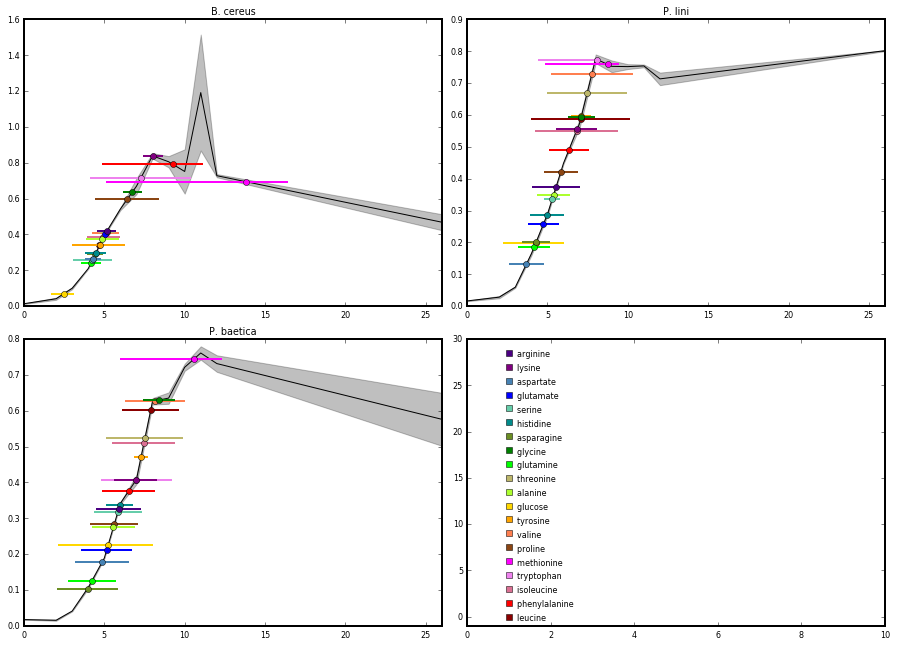

In [56]:
label = [
    'B. cereus',
    'P. lini',
    'P. baetica',
]

for s,strain in enumerate(odavg.columns):
    plt.subplot(2,2,s+1)
    
    #plot the OD data
    plt.plot(odavg.index, odavg[strain], color = 'black', label = odavg.columns[0])
    error = odstderr[strain].tolist()
    plt.fill_between(odavg.index, odavg[strain] - error, odavg[strain] + error, color = 'black', alpha = 0.25)
    
    #plot the t-half and usage window data
    for c,comp in enumerate(halfavg.index):
        w = window_avg.iloc[c,s]
        wt50 = t50df.iloc[c,s]
        thalf = halfavg.iloc[c,s]
        
        #round down and up to nearest hour
        thalf_low = math.floor(thalf)
        thalf_high = math.ceil(thalf)
        
        #conditional statements needed in case the thalf is in between t12 and t26 timepoints - would otherwise not be right
        if thalf_high <= 12:
            for i, j in enumerate(odavg.index):
                if j == thalf_low:
                    idx_low = i
                if j == thalf_high:
                    idx_high = i
            x1=odavg.index[idx_low]
            y1=odavg.iloc[idx_low,s]
            x2=odavg.index[idx_high]
            y2=odavg.iloc[idx_high,s]
        else:
            x1=odavg.index[-2]
            y1=odavg.iloc[-2,s]
            x2=odavg.index[-1]
            y2=odavg.iloc[-1,s]
        #draw a line between two OD timepoints, to plot the t-half correctly
        m = (y2 - y1)/(x2 - x1)
        b = y1 - m * x1
        thalf_od = m * thalf + b
        
        #plot the t-half and width around there
        err = halfstderr.iloc[c,s]
        plt.plot([wt50-(w),wt50+(w)],[thalf_od,thalf_od], color = colors[c], linewidth = 2)
        plt.plot(thalf,thalf_od, 'o', color = colors[c], label = halfavg.index[c].replace('Results Final Conc.',''))
        plt.title(label[s])
        plt.xlim(0,26)
        plt.ylim(0,)

#this plot is for the legend of the figure; what color corresponds to which compound        
plt.subplot(2,2,s+2)
for i,j in enumerate(colors):
    plt.plot(1,i*1.5,marker='s',color = j)
    plt.text(1.2,(i*1.5)-0.4,'%s'%(data['dim2'][i].replace('Results Final Conc.','')))
plt.ylim([-1,30])
plt.xlim([0,10])

fig3 = plt.gcf()
fig3.set_size_inches(12.5, 9)
plt.tight_layout()
plt.show()


### Now dump the data dictionary into a file so you have all the data generated saved

In [57]:
with open("../Data/metabolomics_data_including_fit.pkl",'w') as f:
    pickle.dump(data,f)